In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 258 kB 4.0 MB/s 
     |████████████████████████████████| 1.8 MB 60.5 MB/s 
     |████████████████████████████████| 103 kB 71.9 MB/s 


In [3]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [4]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [5]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [6]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [7]:
%load_ext Cython

In [8]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [9]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [10]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    
    df['kdist_diff'] = (df['kdist'] - df['kdist_country']) /\
                                df['kdist_country']
    df['kneighbors_mean'] = df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return df

In [11]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [12]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [13]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


In [14]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data, CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Num of unique id: 569406
Num of train data: 13928057
Pos rate: 0.07242905453359359
                        id          match_id     kdist  kneighbors  \
2271553   E_fd464ba1740098  E_e9f184d83cae1e  0.007594         3.0   
2195812   E_db1da0832b0edb  E_43d12cd75a508f  0.003153         3.0   
6242880   E_f6b56f1f995bb8  E_559775ec266daa  0.002581        10.0   
9817306   E_3daed89cf926d8  E_7d12548cb02d23  0.001735        17.0   
11950281  E_92c117b8a31433  E_8f8f0ab8d049d3       NaN         NaN   

          kdist_country  kneighbors_country  label  
2271553        0.006657                 2.0      0  
2195812        0.003124                 3.0      0  
6242880        0.002541                10.0      0  
9817306        0.001725                17.0      0  
11950281       0.040197                12.0      0  


In [15]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 569406
Unique id: 569406
IoU score: 0.9231233344021228


In [16]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [17]:
data = data.set_index('id')

In [18]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [19]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        
        print(f"== fold {i} ==")
        trn_idx = folds==((i - 1) % CFG.num_split)
        val_idx = folds==i
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0443063
[100]	valid_0's binary_logloss: 0.0429231
[150]	valid_0's binary_logloss: 0.0423407
[200]	valid_0's binary_logloss: 0.0420226
[250]	valid_0's binary_logloss: 0.0415742
[300]	valid_0's binary_logloss: 0.0413279
[350]	valid_0's binary_logloss: 0.0411236
[400]	valid_0's binary_logloss: 0.0409834
[450]	valid_0's binary_logloss: 0.0408111
[500]	valid_0's binary_logloss: 0.0406695
[550]	valid_0's binary_logloss: 0.0405543
[600]	valid_0's binary_logloss: 0.0404413
[650]	valid_0's binary_logloss: 0.0403686
[700]	valid_0's binary_logloss: 0.0402804
[750]	valid_0's binary_logloss: 0.0402388
[800]	valid_0's binary_logloss: 0.0401831
[850]	valid_0's binary_logloss: 0.0401023
[900]	valid_0's binary_logloss: 0.0400405
[950]	valid_0's binary_logloss: 0.0400165
[1000]	valid_0's binary_logloss: 0.0399899
[1050]	valid_0's binary_logloss: 0.0399324
[1100]	valid_0's binary_logloss: 0.0399031
[1150]	valid_0's binary_logloss: 0.0398616
[1200]	valid_0's binary_logloss

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0441804
[100]	valid_0's binary_logloss: 0.0428326
[150]	valid_0's binary_logloss: 0.0421205
[200]	valid_0's binary_logloss: 0.0417858
[250]	valid_0's binary_logloss: 0.0414269
[300]	valid_0's binary_logloss: 0.0412176
[350]	valid_0's binary_logloss: 0.0409977
[400]	valid_0's binary_logloss: 0.0408076
[450]	valid_0's binary_logloss: 0.0406624
[500]	valid_0's binary_logloss: 0.0405562
[550]	valid_0's binary_logloss: 0.0404425
[600]	valid_0's binary_logloss: 0.0403734

== fold 2 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0438534
[100]	valid_0's binary_logloss: 0.0423606
[150]	valid_0's binary_logloss: 0.0416847
[200]	valid_0's binary_logloss: 0.0413341
[250]	valid_0's binary_logloss: 0.0410565
[300]	valid_0's binary_logloss: 0.0407772
[350]	valid_0's binary_logloss: 0.0405735
[400]	valid_0's binary_logloss: 0.040391
[450]	valid_0's binary_logloss: 0.0402325
[500]	valid_0's binary_logloss: 0.040123
[550]	valid_0's binary_logloss: 0.040015
[600]	valid_0's binary_logloss: 0.0398929
[650]	valid_0's binary_logloss: 0.0397862
[700]	valid_0's binary_logloss: 0.0396815
[750]	valid_0's binary_logloss: 0.0396014
[800]	valid_0's binary_logloss: 0.039525
[850]	valid_0's binary_logloss: 0.0394491
[900]	valid_0's binary_logloss: 0.0393755
[950]	valid_0's binary_logloss: 0.0393177
[1000]	valid_0's binary_logloss: 0.0392629
[1050]	valid_0's binary_logloss: 0.0392243
[1100]	valid_0's binary_logloss: 0.0391877
[1150]	valid_0's binary_logloss: 0.0391421
[1200]	valid_0's binary_logloss: 0.

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0434875
[100]	valid_0's binary_logloss: 0.0422462
[150]	valid_0's binary_logloss: 0.0415902
[200]	valid_0's binary_logloss: 0.0410975
[250]	valid_0's binary_logloss: 0.0408031
[300]	valid_0's binary_logloss: 0.0405775
[350]	valid_0's binary_logloss: 0.0404061
[400]	valid_0's binary_logloss: 0.0401937
[450]	valid_0's binary_logloss: 0.0400445
[500]	valid_0's binary_logloss: 0.0399023
[550]	valid_0's binary_logloss: 0.0398205
[600]	valid_0's binary_logloss: 0.0396955
[650]	valid_0's binary_logloss: 0.0395951
[700]	valid_0's binary_logloss: 0.0395361
[750]	valid_0's binary_logloss: 0.0394626
[800]	valid_0's binary_logloss: 0.0393924
[850]	valid_0's binary_logloss: 0.0393461
[900]	valid_0's binary_logloss: 0.0393033
[950]	valid_0's binary_logloss: 0.039271
[1000]	valid_0's binary_logloss: 0.0392164
[1050]	valid_0's binary_logloss: 0.0391756
[1100]	valid_0's binary_logloss: 0.0391396
[1150]	valid_0's binary_logloss: 0.0391016

== fold 4 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0435387
[100]	valid_0's binary_logloss: 0.0422383
[150]	valid_0's binary_logloss: 0.0415536
[200]	valid_0's binary_logloss: 0.0411339
[250]	valid_0's binary_logloss: 0.0408355
[300]	valid_0's binary_logloss: 0.0405931
[350]	valid_0's binary_logloss: 0.0403754
[400]	valid_0's binary_logloss: 0.0401667
[450]	valid_0's binary_logloss: 0.0399657
[500]	valid_0's binary_logloss: 0.0398288
[550]	valid_0's binary_logloss: 0.039714
[600]	valid_0's binary_logloss: 0.0396226
[650]	valid_0's binary_logloss: 0.0395608
[700]	valid_0's binary_logloss: 0.0394692
[750]	valid_0's binary_logloss: 0.0394129
[800]	valid_0's binary_logloss: 0.0393316
[850]	valid_0's binary_logloss: 0.0392677
[900]	valid_0's binary_logloss: 0.039218
[950]	valid_0's binary_logloss: 0.0391717
[1000]	valid_0's binary_logloss: 0.0391137
[1050]	valid_0's binary_logloss: 0.0390756
[1100]	valid_0's binary_logloss: 0.0390121

CV-accuracy: 0.9862812881940388


In [ ]:
train_data["pred"] = oof[:, -1]

#Check Feature Importances

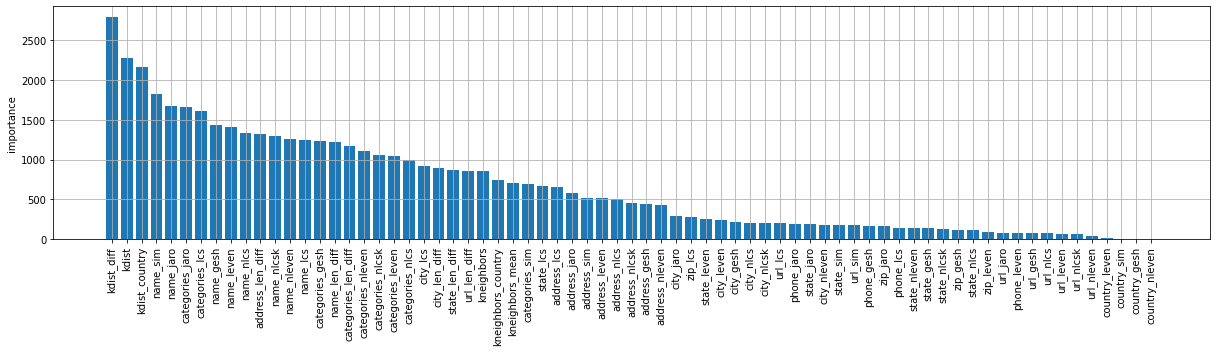

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 8.3 MB/s 
     |████████████████████████████████| 210 kB 68.0 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 65.4 MB/s 
     |████████████████████████████████| 146 kB 69.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c73888edf4a4e75432f4fa2ce95723b7d122266c2e18f9bd830bbd915dfcd26a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-19 23:00:21,831] A new study created in memory with name: no-name-1bddf660-3a00-488d-84bc-31bb1272f4c4
[I 2022-05-19 23:00:44,632] Trial 0 finished with value: 0.7882517803233552 and parameters: {'threshold': 0.16296223522854036}. Best is trial 0 with value: 0.7882517803233552.


CV: 0.788252


[I 2022-05-19 23:01:03,787] Trial 1 finished with value: 0.8319883621326866 and parameters: {'threshold': 0.7058689163012791}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.831988


[I 2022-05-19 23:01:24,881] Trial 2 finished with value: 0.7893107721251739 and parameters: {'threshold': 0.16601061466187372}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.789311


[I 2022-05-19 23:01:44,529] Trial 3 finished with value: 0.820666681830253 and parameters: {'threshold': 0.8130292768785742}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.820667


[I 2022-05-19 23:02:05,367] Trial 4 finished with value: 0.8221753678643935 and parameters: {'threshold': 0.32428418175936424}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.822175


[I 2022-05-19 23:02:26,196] Trial 5 finished with value: 0.8274827421446372 and parameters: {'threshold': 0.37453606647641047}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.827483


[I 2022-05-19 23:02:46,207] Trial 6 finished with value: 0.8194320260265293 and parameters: {'threshold': 0.30399791494148376}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.819432


[I 2022-05-19 23:03:05,943] Trial 7 finished with value: 0.8135567536110268 and parameters: {'threshold': 0.8512123837473395}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.813557


[I 2022-05-19 23:03:27,061] Trial 8 finished with value: 0.7380330773533914 and parameters: {'threshold': 0.0763895343465949}. Best is trial 1 with value: 0.8319883621326866.


CV: 0.738033


[I 2022-05-19 23:03:47,189] Trial 9 finished with value: 0.8354880049647807 and parameters: {'threshold': 0.6088082212735685}. Best is trial 9 with value: 0.8354880049647807.


CV: 0.835488


[I 2022-05-19 23:04:07,191] Trial 10 finished with value: 0.8348403406144325 and parameters: {'threshold': 0.642087477586806}. Best is trial 9 with value: 0.8354880049647807.


CV: 0.834840


[I 2022-05-19 23:04:27,291] Trial 11 finished with value: 0.8356221921756987 and parameters: {'threshold': 0.6009677862336972}. Best is trial 11 with value: 0.8356221921756987.


CV: 0.835622


[I 2022-05-19 23:04:47,492] Trial 12 finished with value: 0.8350366716326032 and parameters: {'threshold': 0.5153019181773392}. Best is trial 11 with value: 0.8356221921756987.


CV: 0.835037


[I 2022-05-19 23:05:07,747] Trial 13 finished with value: 0.8356585675410305 and parameters: {'threshold': 0.5643000576154743}. Best is trial 13 with value: 0.8356585675410305.


CV: 0.835659


[I 2022-05-19 23:05:25,928] Trial 14 finished with value: 0.7261526652819736 and parameters: {'threshold': 0.9853054075199468}. Best is trial 13 with value: 0.8356585675410305.


CV: 0.726153


[I 2022-05-19 23:05:47,031] Trial 15 finished with value: 0.8336561405623795 and parameters: {'threshold': 0.4766892834385856}. Best is trial 13 with value: 0.8356585675410305.


CV: 0.833656


[I 2022-05-19 23:06:07,385] Trial 16 finished with value: 0.8342764145378178 and parameters: {'threshold': 0.49198420393663606}. Best is trial 13 with value: 0.8356585675410305.


CV: 0.834276


[I 2022-05-19 23:06:27,107] Trial 17 finished with value: 0.8253734754699575 and parameters: {'threshold': 0.7787992889191209}. Best is trial 13 with value: 0.8356585675410305.


CV: 0.825373


[I 2022-05-19 23:06:47,298] Trial 18 finished with value: 0.8357014130411858 and parameters: {'threshold': 0.5853877928400341}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835701


[I 2022-05-19 23:07:07,005] Trial 19 finished with value: 0.8305502409793969 and parameters: {'threshold': 0.41510178555062216}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.830550


[I 2022-05-19 23:07:26,091] Trial 20 finished with value: 0.7434083055501607 and parameters: {'threshold': 0.9761398014144306}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.743408


[I 2022-05-19 23:07:46,307] Trial 21 finished with value: 0.8356778271833029 and parameters: {'threshold': 0.5730208885690111}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835678


[I 2022-05-19 23:08:05,662] Trial 22 finished with value: 0.8319231138127583 and parameters: {'threshold': 0.7065948099191595}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.831923


[I 2022-05-19 23:08:25,822] Trial 23 finished with value: 0.835650824403357 and parameters: {'threshold': 0.5644194450573063}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835651


[I 2022-05-19 23:08:45,829] Trial 24 finished with value: 0.8323196213013171 and parameters: {'threshold': 0.6997813541867842}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.832320


[I 2022-05-19 23:09:06,362] Trial 25 finished with value: 0.8313785768603953 and parameters: {'threshold': 0.42821084566020673}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.831379


[I 2022-05-19 23:09:26,567] Trial 26 finished with value: 0.8355214348246464 and parameters: {'threshold': 0.5450571768207099}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835521


[I 2022-05-19 23:09:47,320] Trial 27 finished with value: 0.8129041812409046 and parameters: {'threshold': 0.2611902056284364}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.812904


[I 2022-05-19 23:10:07,399] Trial 28 finished with value: 0.8046985926599465 and parameters: {'threshold': 0.8837538699918915}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.804699


[I 2022-05-19 23:10:27,407] Trial 29 finished with value: 0.8350051095447895 and parameters: {'threshold': 0.6330956726733131}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835005


[I 2022-05-19 23:10:46,295] Trial 30 finished with value: 0.8279407865942432 and parameters: {'threshold': 0.7545675528481937}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.827941


[I 2022-05-19 23:11:06,218] Trial 31 finished with value: 0.835650993714064 and parameters: {'threshold': 0.5703915138309126}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835651


[I 2022-05-19 23:11:26,030] Trial 32 finished with value: 0.8338670364568185 and parameters: {'threshold': 0.6667591860873869}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.833867


[I 2022-05-19 23:11:46,280] Trial 33 finished with value: 0.833111030096622 and parameters: {'threshold': 0.46434551664969514}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.833111


[I 2022-05-19 23:12:06,571] Trial 34 finished with value: 0.8355524085647055 and parameters: {'threshold': 0.5465235915577745}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835552


[I 2022-05-19 23:12:26,221] Trial 35 finished with value: 0.835668335141 and parameters: {'threshold': 0.5775767318719263}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835668


[I 2022-05-19 23:12:46,924] Trial 36 finished with value: 0.8272439713792312 and parameters: {'threshold': 0.3718349160153632}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.827244


[I 2022-05-19 23:13:06,819] Trial 37 finished with value: 0.8294166541427432 and parameters: {'threshold': 0.7394607425975257}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.829417


[I 2022-05-19 23:13:27,333] Trial 38 finished with value: 0.8019991163918859 and parameters: {'threshold': 0.20901184391038813}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.801999


[I 2022-05-19 23:13:47,335] Trial 39 finished with value: 0.8333731661446943 and parameters: {'threshold': 0.679703647285846}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.833373


[I 2022-05-19 23:14:08,187] Trial 40 finished with value: 0.8274902254499784 and parameters: {'threshold': 0.37458025129431205}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.827490


[I 2022-05-19 23:14:28,389] Trial 41 finished with value: 0.835667774222941 and parameters: {'threshold': 0.5780596137425826}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835668


[I 2022-05-19 23:14:48,568] Trial 42 finished with value: 0.8351661351261448 and parameters: {'threshold': 0.5214369115503098}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835166


[I 2022-05-19 23:15:08,877] Trial 43 finished with value: 0.8356329417424939 and parameters: {'threshold': 0.6012565649430286}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.835633


[I 2022-05-19 23:15:28,662] Trial 44 finished with value: 0.8322812669668742 and parameters: {'threshold': 0.4437386757793652}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.832281


[I 2022-05-19 23:15:48,010] Trial 45 finished with value: 0.8348857426651671 and parameters: {'threshold': 0.6397775873625241}. Best is trial 18 with value: 0.8357014130411858.


CV: 0.834886


[I 2022-05-19 23:16:08,182] Trial 46 finished with value: 0.8357097971741835 and parameters: {'threshold': 0.5844086266420833}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835710


[I 2022-05-19 23:16:27,597] Trial 47 finished with value: 0.8355272340680272 and parameters: {'threshold': 0.6060778622009494}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835527


[I 2022-05-19 23:16:47,846] Trial 48 finished with value: 0.8347102804999026 and parameters: {'threshold': 0.5044374548686426}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834710


[I 2022-05-19 23:17:07,540] Trial 49 finished with value: 0.8225464127448068 and parameters: {'threshold': 0.8007479488610129}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.822546


[I 2022-05-19 23:17:27,288] Trial 50 finished with value: 0.8129828758553803 and parameters: {'threshold': 0.853520529708604}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.812983
CV: 0.502246


[I 2022-05-19 23:17:52,658] Trial 51 finished with value: 0.5022464356446232 and parameters: {'threshold': 0.007473136927974577}. Best is trial 46 with value: 0.8357097971741835.
[I 2022-05-19 23:18:12,220] Trial 52 finished with value: 0.83570877167295 and parameters: {'threshold': 0.5826428941260784}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835709


[I 2022-05-19 23:18:32,324] Trial 53 finished with value: 0.8356490952433214 and parameters: {'threshold': 0.5918456063556224}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835649


[I 2022-05-19 23:18:51,479] Trial 54 finished with value: 0.834282646283365 and parameters: {'threshold': 0.6567311599945357}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834283


[I 2022-05-19 23:19:11,813] Trial 55 finished with value: 0.8351035018284714 and parameters: {'threshold': 0.5189925785056679}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835104


[I 2022-05-19 23:19:31,060] Trial 56 finished with value: 0.8324808708845444 and parameters: {'threshold': 0.6969753939474472}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.832481


[I 2022-05-19 23:19:51,456] Trial 57 finished with value: 0.8339730727722691 and parameters: {'threshold': 0.48432922819212443}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.833973


[I 2022-05-19 23:20:11,344] Trial 58 finished with value: 0.8295128694154099 and parameters: {'threshold': 0.7382146449350104}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.829513


[I 2022-05-19 23:20:31,669] Trial 59 finished with value: 0.8287624547289085 and parameters: {'threshold': 0.39142488751542776}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.828762


[I 2022-05-19 23:20:52,309] Trial 60 finished with value: 0.8231384556492214 and parameters: {'threshold': 0.33246943909024806}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.823138


[I 2022-05-19 23:21:12,666] Trial 61 finished with value: 0.8356102321828536 and parameters: {'threshold': 0.5619562117064301}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835610


[I 2022-05-19 23:21:32,249] Trial 62 finished with value: 0.8353041653479311 and parameters: {'threshold': 0.61604065024827}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835304


[I 2022-05-19 23:21:51,745] Trial 63 finished with value: 0.8356948002507824 and parameters: {'threshold': 0.5757695710560775}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835695


[I 2022-05-19 23:22:12,240] Trial 64 finished with value: 0.8356532118250822 and parameters: {'threshold': 0.5875224851848044}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835653


[I 2022-05-19 23:22:31,768] Trial 65 finished with value: 0.8353069457253199 and parameters: {'threshold': 0.5282937839392391}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835307


[I 2022-05-19 23:22:52,000] Trial 66 finished with value: 0.8325728426579635 and parameters: {'threshold': 0.4500747769500457}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.832573


[I 2022-05-19 23:23:12,061] Trial 67 finished with value: 0.8349976056451894 and parameters: {'threshold': 0.6338828556142734}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834998


[I 2022-05-19 23:23:32,528] Trial 68 finished with value: 0.8340704572215453 and parameters: {'threshold': 0.4862876532888916}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834070


[I 2022-05-19 23:23:51,890] Trial 69 finished with value: 0.8357006152089064 and parameters: {'threshold': 0.5746375133899033}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835701


[I 2022-05-19 23:24:11,157] Trial 70 finished with value: 0.835558165874566 and parameters: {'threshold': 0.5462671502487099}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835558


[I 2022-05-19 23:24:31,380] Trial 71 finished with value: 0.8356686796931401 and parameters: {'threshold': 0.5778495809941434}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835669


[I 2022-05-19 23:24:50,470] Trial 72 finished with value: 0.8342992261453104 and parameters: {'threshold': 0.656314762645561}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834299


[I 2022-05-19 23:25:10,623] Trial 73 finished with value: 0.8352532919252625 and parameters: {'threshold': 0.6185374084029174}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835253


[I 2022-05-19 23:25:29,601] Trial 74 finished with value: 0.8312979876545918 and parameters: {'threshold': 0.7152663513748287}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.831298


[I 2022-05-19 23:25:49,700] Trial 75 finished with value: 0.8353364160363651 and parameters: {'threshold': 0.5317486716968786}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835336


[I 2022-05-19 23:26:10,212] Trial 76 finished with value: 0.8356969493438157 and parameters: {'threshold': 0.5677851784418505}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835697


[I 2022-05-19 23:26:30,052] Trial 77 finished with value: 0.8334243052487451 and parameters: {'threshold': 0.6783778350987516}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.833424


[I 2022-05-19 23:26:50,092] Trial 78 finished with value: 0.8355520563051867 and parameters: {'threshold': 0.5502382586600817}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.835552


[I 2022-05-19 23:27:10,469] Trial 79 finished with value: 0.8345303725180254 and parameters: {'threshold': 0.49835854608818486}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.834530


[I 2022-05-19 23:27:30,141] Trial 80 finished with value: 0.8308290258938932 and parameters: {'threshold': 0.4191746785130466}. Best is trial 46 with value: 0.8357097971741835.


CV: 0.830829


[I 2022-05-19 23:27:49,496] Trial 81 finished with value: 0.8357202148894373 and parameters: {'threshold': 0.5842508575761385}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835720


[I 2022-05-19 23:28:09,621] Trial 82 finished with value: 0.8356719997482404 and parameters: {'threshold': 0.5767828304184107}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835672


[I 2022-05-19 23:28:28,953] Trial 83 finished with value: 0.835095491358374 and parameters: {'threshold': 0.6271586464221575}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835095


[I 2022-05-19 23:28:49,124] Trial 84 finished with value: 0.8332879831919822 and parameters: {'threshold': 0.4685861638318438}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.833288


[I 2022-05-19 23:29:09,069] Trial 85 finished with value: 0.8354700627358123 and parameters: {'threshold': 0.6089878352646658}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835470


[I 2022-05-19 23:29:29,311] Trial 86 finished with value: 0.8355486686567403 and parameters: {'threshold': 0.5583189482362736}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835549


[I 2022-05-19 23:29:48,792] Trial 87 finished with value: 0.834486047767142 and parameters: {'threshold': 0.6520021310033866}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.834486


[I 2022-05-19 23:30:08,464] Trial 88 finished with value: 0.8349837463363463 and parameters: {'threshold': 0.5123581774149361}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.834984


[I 2022-05-19 23:30:28,490] Trial 89 finished with value: 0.8332479532222579 and parameters: {'threshold': 0.6833980963912835}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.833248


[I 2022-05-19 23:30:47,871] Trial 90 finished with value: 0.8356578449507345 and parameters: {'threshold': 0.5898543863011274}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835658


[I 2022-05-19 23:31:08,139] Trial 91 finished with value: 0.8354604995218444 and parameters: {'threshold': 0.5408106213012623}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835460


[I 2022-05-19 23:31:28,438] Trial 92 finished with value: 0.8356881589459285 and parameters: {'threshold': 0.573535571615418}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835688


[I 2022-05-19 23:31:47,896] Trial 93 finished with value: 0.8356659282878746 and parameters: {'threshold': 0.5779029930666352}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835666


[I 2022-05-19 23:32:07,939] Trial 94 finished with value: 0.834889261613309 and parameters: {'threshold': 0.6391440725032407}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.834889


[I 2022-05-19 23:32:27,319] Trial 95 finished with value: 0.8355193042258565 and parameters: {'threshold': 0.6066359327995705}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835519


[I 2022-05-19 23:32:47,378] Trial 96 finished with value: 0.834812206310405 and parameters: {'threshold': 0.5075982795532947}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.834812


[I 2022-05-19 23:33:07,445] Trial 97 finished with value: 0.8355864407253771 and parameters: {'threshold': 0.5599568022390887}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835586


[I 2022-05-19 23:33:27,501] Trial 98 finished with value: 0.835320295113491 and parameters: {'threshold': 0.5307504175490327}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.835320


[I 2022-05-19 23:33:47,232] Trial 99 finished with value: 0.8308423954076375 and parameters: {'threshold': 0.7209288401395201}. Best is trial 81 with value: 0.8357202148894373.


CV: 0.830842


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5842508575761385

In [ ]:
study.best_value

0.8357202148894373

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.835720
